# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline



This image is: <class 'numpy.ndarray'> with dimesions: (540, 960)


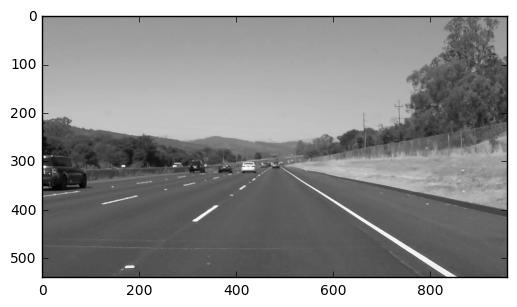

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#printing out some stats and plotting
print('This image is:', type(gray), 'with dimesions:', gray.shape)
plt.imshow(gray, cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math
Horizon = 325         # Y dimension for masked region. In case it needs to be dynamic in future releases
lPrevSlope = -0.6
rPrevSlope = 0.6

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color, thickness, r, l,XTR,XBR, XTL, XBL, Y_prev):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    global rPrevSlope
    global lPrevSlope
    global X_topRight_prev
    global X_bottomRight_prev
    global Y_minPoint_prev
    global X_topLeft_prev
    global X_bottomLeft_prev
    
    #print(lines)
    Y_minPoint = 1000
    Y_maxPoint = 0
    rSlope = []
    rPAvg = []
    m_rPAvg = []
    lSlope = []
    lPAvg =[]
    m_lPAvg = []
    
    for line in lines:

        for x1,y1,x2,y2 in line:
            #print(x1,y1,x2,y2)
            if y1<Y_minPoint: Y_minPoint = y1
            if y2>Y_maxPoint: Y_maxPoint = y2
            #print("length = ",((x1-x2)**2+(y1-y2)**2)**0.5)
            #print("slope = ",((y2-y1)/(x2-x1)))
            slope = ((y2-y1)/(x2-x1))
            length = ((x1-x2)**2+(y1-y2)**2)**0.5
            if slope > 0:
                rSlope.append(slope)
                rPAvg.append([x1,y1])
                rPAvg.append([x2,y2])
                
                
            else:
                lSlope.append(slope)
                lPAvg.append([x1,y1])
                lPAvg.append([x2,y2])
            
    
    m_lPAvg = np.array(lPAvg)
    m_rPAvg = np.array(rPAvg)
    mrSlope = np.mean(rSlope)
    mlSlope = np.mean(lSlope)
    if abs((mrSlope - r)/r )> 0.1:  # replace outlier slopes with previous ones
        print("Outlier right line slope detected, Slope: ",mrSlope,"% Change",abs((mrSlope - r)/r))
        mrSlope = r
        print("Previous Right Slope:",mrSlope)
        X_topRight = XTR
        X_bottomRight = XBR
        Y_minPoint = Y_prev
        cv2.line(img,(X_topRight,Y_minPoint),(X_bottomRight,img.shape[0]),color,thickness)
    else:
        rPrevSlope = mrSlope
        Y_minPoint_prev = Y_minPoint
        
        try:   
            xRAvg = np.mean(m_rPAvg[:,0])
            yRAvg = np.mean(m_rPAvg[:,1])
            X_topRight = int(xRAvg + ((Y_minPoint - yRAvg) / mrSlope))
            X_bottomRight = int(xRAvg + ((img.shape[0] - yRAvg) / mrSlope))  
            cv2.line(img,(X_topRight,Y_minPoint),(X_bottomRight,img.shape[0]),color,thickness)
            X_topRight_prev = X_topRight
            X_bottomRight_prev = X_bottomRight

        except IndexError:
            print("Emty matrix for right line")

    
    if abs((mlSlope - l)/l)> 0.1:
        print("Outlier left line slope detected: ",mlSlope, "% of Change", abs((mlSlope - l)/l))
        mlSlope = l
        print("Previous Left Slope:",mlSlope)
        X_topLeft = XTL
        X_bottomLeft = XBL
        Y_minPoint = Y_prev
        cv2.line(img,(X_topLeft,Y_minPoint),(X_bottomLeft,img.shape[0]),color,thickness)
    else:
        lPrevSlope = mlSlope 
        #print(mlSlope)
        Y_minPoint_prev = Y_minPoint        
        try:
            xLAvg = np.mean(m_lPAvg[:,0])
            yLAvg = np.mean(m_lPAvg[:,1])
            X_topLeft = int(xLAvg + ((Y_minPoint - yLAvg) / mlSlope))
            X_bottomLeft = int(xLAvg + ((img.shape[0] - yLAvg) / mlSlope))  
            cv2.line(img,(X_topLeft,Y_minPoint),(X_bottomLeft,img.shape[0]),color,thickness)
            X_topLeft_prev = X_topLeft
            X_bottomLeft_prev = X_bottomLeft
        except IndexError:
            print("Empty matrix for left line")

            
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, rPrevSlope, lPrevSlope,XTR,XBR,XTL,XBL,Y_prev):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    #print("Hough Lines function: ", rPrevSlope, lPrevSlope)
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, [255,0,0], 3,rPrevSlope, lPrevSlope,XTR,XBR,XTL,XBL,Y_prev)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
imFile = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

solidWhiteCurve.jpg
solidWhiteRight.jpg
Outlier right line slope detected, Slope:  0.638294520007 % Change 0.137156419566
Previous Right Slope: 0.561307581811
Outlier left line slope detected:  -0.694733251173 % of Change 0.105398220001
Previous Left Slope: -0.776583801537
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg
Outlier left line slope detected:  -0.798358406307 % of Change 0.11834620386
Previous Left Slope: -0.713874114788


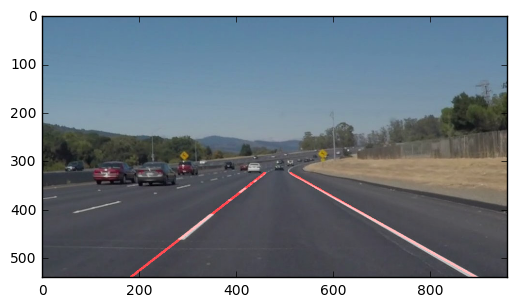

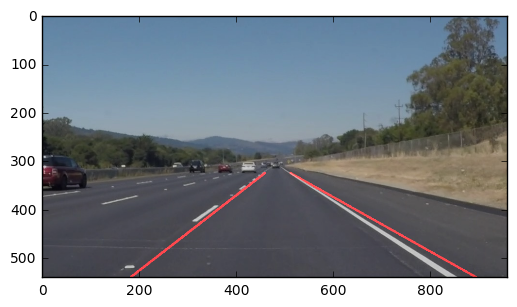

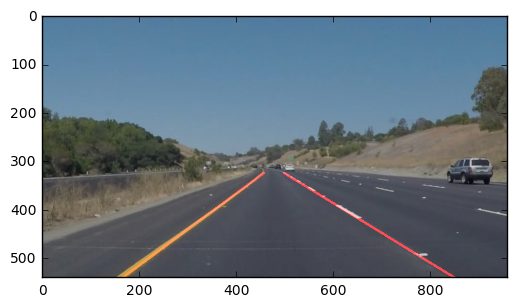

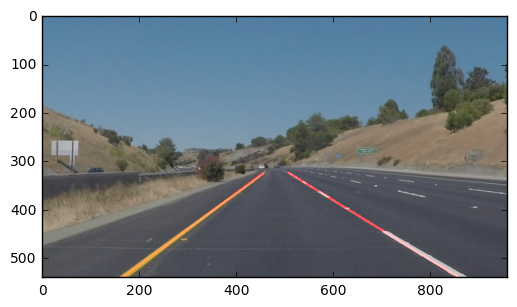

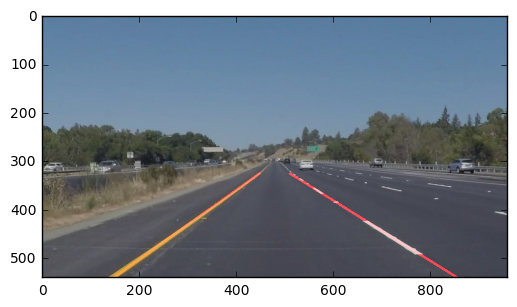

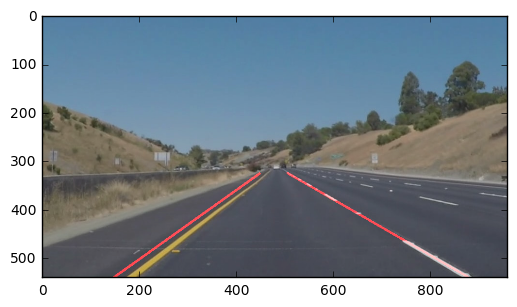

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#imFile = 'solidWhiteCurve.jpg'
#print (imFile)
#for x in imFile:


rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50    # minimum number of votes (intersections in Hough grid cell)
min_line_len = 15 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments
rPrevSlope = 0.6
lPrevSlope = -0.77
X_topRight_prev = 0
X_bottomRight_prev =0
Y_minPoint_prev = 0
X_topLeft_prev = 0
X_bottomLeft_prev = 0

for root, dirs, files in os.walk("test_images/"):
    for x in files:
        
        image = mpimg.imread(os.path.join(root,x))
        print(x)
        #print(image.shape)
        gray = grayscale(image)
        #print('This image is:', type(gray), 'with dimesions:', gray.shape)
        #plt.figure()
        
        #plt.imshow(gray,cmap = 'gray')
        #print('This image is:', type(gray), 'with dimesions:', gray.shape)
        
        blurgray = gaussian_blur(gray,5)
        edges = canny(blurgray, 30, 100)
        
        #plt.figure()
        #plt.imshow(edges,cmap = 'gray')
        
        vertices = np.array([[(145,image.shape[0]),(430,Horizon),(520,Horizon),(900,image.shape[0])]],dtype=np.int32)
        
        maskedImg = region_of_interest(edges,vertices)
        maskedImgC = region_of_interest(image,vertices)
        
        #plt.figure()
        #plt.imshow(maskedImgC,cmap='gray')
        
        lineImg = hough_lines(maskedImg,rho, theta, threshold, min_line_len, max_line_gap, rPrevSlope, lPrevSlope, X_topRight_prev,X_bottomRight_prev, X_topLeft_prev, X_bottomLeft_prev,Y_minPoint_prev)
        
        #plt.figure()
        #plt.imshow(lineImg,cmap='gray')
        
        finalImg = weighted_img(lineImg, image)
        plt.figure()
        plt.imshow(finalImg)
        

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    

    
    
    #image = mpimg.imread(os.path.join(root,x))
    #vertices = np.array([[(200,image.shape[1]),(450,325),(505,325),(850,image.shape[1])]],dtype=np.int32)
    #print ("first call for prev slope", rPrevSlope, lPrevSlope)
    gray = grayscale(image)
    blurgray = gaussian_blur(gray,5)
    edges = canny(blurgray, 30, 200)
    maskedImg = region_of_interest(edges,vertices)
    lineImg = hough_lines(maskedImg,rho, theta, threshold, min_line_len, max_line_gap, rPrevSlope, lPrevSlope, X_topRight_prev, X_bottomRight_prev, X_topLeft_prev, X_bottomLeft_prev, Y_minPoint_prev)
    finalImg = weighted_img(lineImg, image)
    
    result = finalImg
    return result

Let's try the one with the solid white lane on the right first ...

In [10]:
#Initialize values for Prev Slope

rPrevSlope = 0.6
lPrevSlope = -0.7
X_topRight_prev = 0
X_bottomRight_prev =0
Y_minPoint_prev = 0
X_topLeft_prev = 0
X_bottomLeft_prev = 0


white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


 46%|████▋     | 103/222 [00:05<00:08, 14.83it/s]

Empty matrix for left line


100%|█████████▉| 221/222 [00:16<00:00,  8.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.02 s, sys: 1.18 s, total: 5.2 s
Wall time: 18.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
#Initialize values for Prev Slope
#Initialize values for Prev Slope

rPrevSlope = 0.7
lPrevSlope = -0.7
X_topRight_prev = 0
X_bottomRight_prev =0
Y_minPoint_prev = 0
X_topLeft_prev = 0
X_bottomLeft_prev = 0


yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


 42%|████▏     | 286/682 [00:30<01:28,  4.48it/s]

Outlier right line slope detected, Slope:  0.498942467907 % Change 0.139341053409
Previous Right Slope: 0.579721467933


 42%|████▏     | 289/682 [00:30<01:29,  4.41it/s]

Outlier right line slope detected, Slope:  0.473894027568 % Change 0.199470722876
Previous Right Slope: 0.591975885342


 43%|████▎     | 290/682 [00:30<01:14,  5.25it/s]

Outlier right line slope detected, Slope:  0.519008107648 % Change 0.123261402198
Previous Right Slope: 0.591975885342
Outlier right line slope detected, Slope:  0.477624438512 % Change 0.193169096345
Previous Right Slope: 0.591975885342


 43%|████▎     | 292/682 [00:31<01:21,  4.77it/s]

Outlier left line slope detected:  -0.601420377945 % of Change 0.160238134661
Previous Left Slope: -0.716179672795


 51%|█████▏    | 351/682 [00:42<01:09,  4.78it/s]

Outlier left line slope detected:  -0.783215484977 % of Change 0.105956883317
Previous Left Slope: -0.708179040966


 99%|█████████▉| 677/682 [01:27<00:00, 12.68it/s]

Outlier left line slope detected:  -0.523332740642 % of Change 0.201909881388
Previous Left Slope: -0.655731387268


100%|█████████▉| 681/682 [01:28<00:00, 12.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.8 s, sys: 3.67 s, total: 16.5 s
Wall time: 1min 30s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!




I started the project by following the algorithm step by step and testing it on the still photos. The results were great. 

The line drawing (extrapolation) algorithm, determines the average slope of all detected lines, left and right lines seperately. Moreover, the algorithm calculates the average X and Y points of for both set of lines from which it draws a line to the bottom of the scene to the top (Horizon) of the masked area.

Outliers identification: Throughout the yellow line video, the algorithm I developed would draw lines that do not fit the actual scene, and hence had to cancel outliers, by replacing these lines with another from the previous scene. after updating the code with this algorithms, the lines on the still photos didn't perfectly fit the actual scene because the algorithm detects high slope changes and replace the lines with previous scene, in this case the previous photo.

Regarding the optional challenge, I would like to find a way to enhance my algorithm by dynamically defining the masked region, especially in the case of sharp turns, in order to filter out un-wanted canny edges from other parts of the scene. In this case the algorithm detected other lines in the image.

Another way to improve the algorithim is to find a way to select inner lines, rather than considering average slope, and average X.Y positions for extrapolation.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
rPrevSlope = 0.5
lPrevSlope = -0.5


challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Outlier left line slope detected:  -0.225862738525 % of Change 0.54827452295
Previous Left Slope: -0.5
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

Outlier left line slope detected:  -0.225862738525 % of Change 0.54827452295
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.574831601147 % Change 0.135854376925
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.258803398445 % of Change 0.48239320311
Previous Left Slope: -0.5


  2%|▏         | 6/251 [00:00<00:30,  7.99it/s]

Outlier right line slope detected, Slope:  0.344006047674 % Change 0.320251749976
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.227596446883 % of Change 0.544807106234
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.441863163428 % Change 0.126888279664
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.185541289383 % of Change 0.628917421233
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.386402581349 % Change 0.236477148431
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.241882512419 % of Change 0.516234975161
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.366992034892 % Change 0.274831953746
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.242746285858 % of Change 0.514507428285
Previous Left Slope: -0.5


  3%|▎         | 8/251 [00:00<00:26,  9.12it/s]

Outlier right line slope detected, Slope:  0.387857760153 % Change 0.233601747686
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.250408221112 % of Change 0.499183557775
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.347041014738 % Change 0.314254722991
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.234411404238 % of Change 0.531177191524
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.302469581265 % Change 0.402326877852
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.173855207954 % of Change 0.652289584091
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.37074112538 % Change 0.267423834862
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.251008050405 % of Change 0.497983899191
Previous Left Slope: -0.5


  6%|▌         | 14/251 [00:01<00:18, 12.61it/s]

Outlier right line slope detected, Slope:  0.25202314546 % Change 0.502007905818
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.182822945242 % of Change 0.634354109516
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.264629499341 % Change 0.477098032728
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.280908457452 % of Change 0.438183085096
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.323899314462 % Change 0.359982204736
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.23704786914 % of Change 0.525904261719
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.280521082078 % Change 0.445696620955
Previous Right Slope: 0.50607860728
Outlier left line slope detected:  -0.188783671725 % of Change 0.62243265655
Previous Left Slope: -0.5


  6%|▋         | 16/251 [00:01<00:19, 12.19it/s]

Outlier left line slope detected:  -0.22082057508 % of Change 0.558358849839
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.269549469418 % Change 0.42180462754
Previous Right Slope: 0.466190983631
Outlier left line slope detected:  -0.247667218498 % of Change 0.504665563003
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.326327841404 % Change 0.300012542365
Previous Right Slope: 0.466190983631
Outlier left line slope detected:  -0.211891048471 % of Change 0.576217903058
Previous Left Slope: -0.5


  8%|▊         | 20/251 [00:01<00:18, 12.74it/s]

Outlier right line slope detected, Slope:  0.239095536847 % Change 0.487129641623
Previous Right Slope: 0.466190983631
Outlier left line slope detected:  -0.224136551686 % of Change 0.551726896629
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.29565857875 % Change 0.365799448872
Previous Right Slope: 0.466190983631
Outlier left line slope detected:  -0.250079984284 % of Change 0.499840031431
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.351132138665 % Change 0.246806242518
Previous Right Slope: 0.466190983631
Outlier left line slope detected:  -0.231302400121 % of Change 0.537395199758
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.308750078512 % Change 0.337717610694
Previous Right Slope: 0.466190983631
Outlier left line slope detected:  -0.276951670071 % of Change 0.446096659859
Previous Left Slope: -0.5


 10%|▉         | 24/251 [00:01<00:16, 13.87it/s]

Outlier right line slope detected, Slope:  0.259767479942 % Change 0.442787421759
Previous Right Slope: 0.466190983631
Outlier left line slope detected:  -0.267694005544 % of Change 0.464611988911
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.207383302396 % of Change 0.585233395208
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.309014359368 % Change 0.26912165342
Previous Right Slope: 0.422798624168
Outlier left line slope detected:  -0.267935652611 % of Change 0.464128694779
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.21918733322 % of Change 0.561625333559
Previous Left Slope: -0.5


 11%|█         | 28/251 [00:02<00:15, 14.47it/s]

Outlier right line slope detected, Slope:  0.333305538357 % Change 0.277710720095
Previous Right Slope: 0.461457130308
Outlier left line slope detected:  -0.277747099635 % of Change 0.44450580073
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.258483686969 % Change 0.439853303823
Previous Right Slope: 0.461457130308
Outlier left line slope detected:  -0.244368593457 % of Change 0.511262813086
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.297298349035 % Change 0.355740047106
Previous Right Slope: 0.461457130308
Outlier left line slope detected:  -0.190422092851 % of Change 0.619155814298
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.34400658444 % Change 0.254521033816
Previous Right Slope: 0.461457130308
Outlier left line slope detected:  -0.28826927071 % of Change 0.42346145858
Previous Left Slope: -0.5


 13%|█▎        | 32/251 [00:02<00:14, 14.90it/s]

Outlier right line slope detected, Slope:  0.361087971302 % Change 0.217504839375
Previous Right Slope: 0.461457130308
Outlier left line slope detected:  -0.236564471498 % of Change 0.526871057004
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.294335015324 % Change 0.362161735094
Previous Right Slope: 0.461457130308
Outlier left line slope detected:  -0.206801669224 % of Change 0.586396661551
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.208006137067 % of Change 0.583987725867
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.315412727733 % Change 0.261364065496
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.21717535704 % of Change 0.565649285921
Previous Left Slope: -0.5


 14%|█▍        | 36/251 [00:02<00:14, 14.66it/s]

Outlier right line slope detected, Slope:  0.263051067445 % Change 0.383985001427
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.129068622049 % of Change 0.741862755902
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.497888016312 % Change 0.165957958799
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.227382445546 % of Change 0.545235108908
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.244688565397 % Change 0.42698644895
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.230522579056 % of Change 0.538954841887
Previous Left Slope: -0.5


 15%|█▌        | 38/251 [00:02<00:14, 14.80it/s]

Outlier right line slope detected, Slope:  0.494184493167 % Change 0.157285020017
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.244784121841 % of Change 0.510431756318
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.360812099281 % Change 0.155047470506
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.186139253647 % of Change 0.627721492707
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.289707141219 % Change 0.321561604301
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.17271164314 % of Change 0.65457671372
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.508411730198 % Change 0.190602472344
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.171781056651 % of Change 0.656437886698
Previous Left Slope: -0.5


 17%|█▋        | 42/251 [00:03<00:14, 14.77it/s]

Outlier right line slope detected, Slope:  0.324751341478 % Change 0.239494828513
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.231497553354 % of Change 0.537004893293
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.474306373971 % Change 0.110734288681
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.195213710838 % of Change 0.609572578324
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.496469058697 % Change 0.162635033021
Previous Right Slope: 0.427020556406
Outlier left line slope detected:  -0.172783603018 % of Change 0.654432793963
Previous Left Slope: -0.5


 18%|█▊        | 46/251 [00:03<00:14, 14.04it/s]

Outlier left line slope detected:  -0.200892621542 % of Change 0.598214756916
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.32190212955 % Change 0.289410541463
Previous Right Slope: 0.453007183942
Outlier left line slope detected:  -0.169797347698 % of Change 0.660405304603
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.539083228126 % Change 0.190010329275
Previous Right Slope: 0.453007183942
Outlier left line slope detected:  -0.190157312886 % of Change 0.619685374229
Previous Left Slope: -0.5


 19%|█▉        | 48/251 [00:03<00:18, 11.08it/s]

Outlier left line slope detected:  -0.180572080134 % of Change 0.638855839732
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.332156835238 % Change 0.196220236472
Previous Right Slope: 0.413243590234
Outlier left line slope detected:  -0.170613615859 % of Change 0.658772768283
Previous Left Slope: -0.5


 20%|█▉        | 50/251 [00:03<00:19, 10.09it/s]

Outlier right line slope detected, Slope:  0.605575425944 % Change 0.465420009543
Previous Right Slope: 0.413243590234
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.188014633997 % of Change 0.623970732005
Previous Left Slope: -0.5


 21%|██        | 52/251 [00:04<00:21,  9.34it/s]

Outlier right line slope detected, Slope:  0.525929740641 % Change 0.275728733645
Previous Right Slope: 0.412258285614
Outlier left line slope detected:  -0.137347698468 % of Change 0.725304603065
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.614381191423 % Change 0.490282215938
Previous Right Slope: 0.412258285614
Outlier left line slope detected:  -0.23841758878 % of Change 0.523164822439
Previous Left Slope: -0.5


 22%|██▏       | 54/251 [00:04<00:21,  8.99it/s]

Outlier right line slope detected, Slope:  0.554108610043 % Change 0.344081197102
Previous Right Slope: 0.412258285614
Outlier left line slope detected:  -0.145750336784 % of Change 0.708499326432
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.219292025733 % of Change 0.561415948534
Previous Left Slope: -0.5


 22%|██▏       | 56/251 [00:04<00:23,  8.25it/s]

Outlier right line slope detected, Slope:  0.547342698855 % Change 0.285675672771
Previous Right Slope: 0.425723773458
Outlier left line slope detected:  -0.208573027387 % of Change 0.582853945226
Previous Left Slope: -0.5
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 23%|██▎       | 58/251 [00:04<00:24,  7.85it/s]

Outlier right line slope detected, Slope:  0.359290937332 % Change 0.180941889476
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.225907598507 % of Change 0.548184802987
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.745401115114 % Change 0.699254741748
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 24%|██▍       | 60/251 [00:05<00:24,  7.86it/s]

Outlier right line slope detected, Slope:  0.293671588954 % Change 0.330531132931
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.364182689627 % Change 0.169790399205
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 25%|██▍       | 62/251 [00:05<00:28,  6.75it/s]

Outlier right line slope detected, Slope:  0.585037015351 % Change 0.333680487292
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.138252303682 % of Change 0.723495392636
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.234104557341 % Change 0.466323203628
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.171264909686 % of Change 0.657470180629
Previous Left Slope: -0.5


 25%|██▌       | 64/251 [00:05<00:28,  6.64it/s]

Outlier right line slope detected, Slope:  0.363681187089 % Change 0.1709336502
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.19868659767 % of Change 0.60262680466
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.340160180434 % Change 0.224553347404
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.161865327463 % of Change 0.676269345075
Previous Left Slope: -0.5


 26%|██▋       | 66/251 [00:06<00:27,  6.79it/s]

Outlier right line slope detected, Slope:  0.322696127731 % Change 0.264365300679
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.183264840146 % of Change 0.633470319708
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.48922843854 % Change 0.115270325106
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.565648897883 % of Change 0.131297795765
Previous Left Slope: -0.5


 27%|██▋       | 68/251 [00:06<00:27,  6.74it/s]

Outlier right line slope detected, Slope:  0.290935315822 % Change 0.336768881979
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.248054511188 % Change 0.434522170947
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 27%|██▋       | 69/251 [00:06<00:27,  6.57it/s]

Outlier right line slope detected, Slope:  0.380742801759 % Change 0.132039115375
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 28%|██▊       | 70/251 [00:06<00:35,  5.05it/s]

Outlier right line slope detected, Slope:  inf % Change inf
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 28%|██▊       | 71/251 [00:07<00:39,  4.60it/s]

Outlier right line slope detected, Slope:  0.996243349993 % Change 1.27108760919
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.726034845238 % Change 0.655106396312
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 29%|██▉       | 73/251 [00:07<00:39,  4.55it/s]

Outlier right line slope detected, Slope:  0.232391589237 % Change 0.47022817387
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 30%|██▉       | 75/251 [00:07<00:34,  5.11it/s]

Outlier right line slope detected, Slope:  0.291217822723 % Change 0.336124864709
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  1.31532547483 % Change 1.99848364153
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 30%|███       | 76/251 [00:08<00:38,  4.56it/s]

Outlier right line slope detected, Slope:  1.72073772867 % Change 2.92268227865
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 31%|███       | 77/251 [00:08<00:44,  3.92it/s]

Outlier right line slope detected, Slope:  2.40179567758 % Change 4.47525702749
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 31%|███       | 78/251 [00:08<00:40,  4.31it/s]

Outlier right line slope detected, Slope:  0.183261083951 % Change 0.582228602067
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.193927173086 % of Change 0.612145653827
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.177568368863 % Change 0.59520600834
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 32%|███▏      | 81/251 [00:09<00:33,  5.02it/s]

Outlier right line slope detected, Slope:  0.258821301982 % Change 0.409977640574
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.169057254093 % of Change 0.661885491814
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.165369949003 % Change 0.623014154007
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.136085481083 % of Change 0.727829037835
Previous Left Slope: -0.5


 33%|███▎      | 82/251 [00:09<00:46,  3.66it/s]

Outlier right line slope detected, Slope:  1.31905135965 % Change 2.00697736029
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.138069766736 % of Change 0.723860466527
Previous Left Slope: -0.5


 33%|███▎      | 84/251 [00:10<00:35,  4.71it/s]

Outlier right line slope detected, Slope:  0.276105908584 % Change 0.370574761866
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.111232746589 % of Change 0.777534506822
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.234535681011 % Change 0.465340391924
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.125312036398 % of Change 0.749375927205
Previous Left Slope: -0.5


 34%|███▍      | 86/251 [00:10<00:30,  5.44it/s]

Outlier right line slope detected, Slope:  0.374952643067 % Change 0.145238659102
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.116802842853 % of Change 0.766394314293
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.274995927781 % Change 0.373105131226
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.120070550583 % of Change 0.759858898834
Previous Left Slope: -0.5


 35%|███▍      | 87/251 [00:10<00:32,  5.05it/s]

Outlier right line slope detected, Slope:  0.217819586527 % Change 0.503447261151
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.139564816756 % of Change 0.720870366488
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.256366178444 % Change 0.415574466537
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.154101931132 % of Change 0.691796137736
Previous Left Slope: -0.5


 36%|███▌      | 90/251 [00:11<00:27,  5.87it/s]

Outlier right line slope detected, Slope:  0.706694178109 % Change 0.61101641622
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.154752944508 % of Change 0.690494110985
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.338185539311 % Change 0.229054840926
Previous Right Slope: 0.438663548673
Outlier left line slope detected:  -0.148386158181 % of Change 0.703227683638
Previous Left Slope: -0.5


 37%|███▋      | 92/251 [00:11<00:23,  6.65it/s]

Outlier left line slope detected:  -0.150084831912 % of Change 0.699830336176
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.0694347182871 % Change 0.852580377263
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 37%|███▋      | 94/251 [00:11<00:24,  6.51it/s]

Outlier right line slope detected, Slope:  15.1916666667 % Change 31.2540340625
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.0360248447205 % Change 0.923514213798
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.158508970611 % of Change 0.682982058778
Previous Left Slope: -0.5


 38%|███▊      | 96/251 [00:11<00:22,  6.86it/s]

Outlier right line slope detected, Slope:  0.0734977862113 % Change 0.843953915525
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.144458490245 % of Change 0.711083019511
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  2.62928571429 % Change 4.58234148033
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 39%|███▉      | 98/251 [00:12<00:21,  7.08it/s]

Outlier right line slope detected, Slope:  0.271376150663 % Change 0.423830459206
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.153088611487 % of Change 0.693822777026
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.293581607979 % Change 0.376685166173
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 40%|███▉      | 100/251 [00:12<00:21,  7.10it/s]

Outlier right line slope detected, Slope:  0.301420214715 % Change 0.360042707237
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  3.98951576245 % Change 7.47030020592
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.126228623043 % of Change 0.747542753914
Previous Left Slope: -0.5


 41%|████      | 102/251 [00:12<00:21,  7.04it/s]

Outlier right line slope detected, Slope:  0.384211086985 % Change 0.184266100703
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.162257683014 % of Change 0.675484633972
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  1.09023905566 % Change 1.3147300694
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.124618246705 % of Change 0.750763506591
Previous Left Slope: -0.5


 41%|████▏     | 104/251 [00:13<00:21,  6.97it/s]

Outlier right line slope detected, Slope:  1.48180288014 % Change 2.14607485924
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.129143111696 % of Change 0.741713776609
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.421812851825 % Change 0.104432292434
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.145458059335 % of Change 0.70908388133
Previous Left Slope: -0.5


 42%|████▏     | 106/251 [00:13<00:20,  7.13it/s]

Outlier right line slope detected, Slope:  0.268149387119 % Change 0.430681329721
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.158783205768 % of Change 0.682433588463
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.209511823707 % Change 0.555177081843
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.168056269576 % of Change 0.663887460849
Previous Left Slope: -0.5


 43%|████▎     | 107/251 [00:13<00:20,  7.10it/s]

Outlier right line slope detected, Slope:  0.298530101435 % Change 0.366178822137
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.159767351437 % of Change 0.680465297126
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.265106389031 % Change 0.43714204046
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 44%|████▍     | 110/251 [00:13<00:19,  7.16it/s]

Outlier right line slope detected, Slope:  0.18697184851 % Change 0.603032603143
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.257190146492 % Change 0.453949331069
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.176233303434 % of Change 0.647533393131
Previous Left Slope: -0.5


 45%|████▍     | 112/251 [00:14<00:19,  7.08it/s]

Outlier right line slope detected, Slope:  0.346121108106 % Change 0.265136455691
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.153064630776 % of Change 0.693870738448
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.191919819839 % Change 0.592527367656
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.112748208272 % of Change 0.774503583456
Previous Left Slope: -0.5


 45%|████▌     | 114/251 [00:14<00:19,  7.16it/s]

Outlier right line slope detected, Slope:  0.334602176681 % Change 0.28959275892
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.15714842559 % of Change 0.685703148819
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.333785317124 % Change 0.29132706606
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.168521244485 % of Change 0.66295751103
Previous Left Slope: -0.5


 46%|████▌     | 116/251 [00:14<00:18,  7.34it/s]

Outlier right line slope detected, Slope:  0.348565058876 % Change 0.259947606232
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.106106779086 % of Change 0.787786441828
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.332522723727 % Change 0.294007728514
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 47%|████▋     | 118/251 [00:15<00:17,  7.41it/s]

Outlier right line slope detected, Slope:  0.313190975671 % Change 0.335051734676
Previous Right Slope: 0.471000515384
Outlier left line slope detected:  -0.133646282438 % of Change 0.732707435123
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.149194935603 % of Change 0.701610128794
Previous Left Slope: -0.5


 47%|████▋     | 119/251 [00:15<00:20,  6.41it/s]

Outlier right line slope detected, Slope:  0.275664685903 % Change 0.376104962987
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -0.150402095259 % of Change 0.699195809482
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.33459057378 % Change 0.242741602068
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -0.14381126318 % of Change 0.712377473639
Previous Left Slope: -0.5


 48%|████▊     | 121/251 [00:15<00:19,  6.60it/s]

Outlier right line slope detected, Slope:  0.262308098678 % Change 0.406334110596
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -0.184045313256 % of Change 0.631909373487
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.233396762911 % Change 0.47176736999
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 49%|████▉     | 123/251 [00:15<00:19,  6.66it/s]

Outlier right line slope detected, Slope:  0.205431560895 % Change 0.535059302688
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -0.148333717452 % of Change 0.703332565095
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.292794988933 % Change 0.337334995015
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -0.223792296582 % of Change 0.552415406837
Previous Left Slope: -0.5


 50%|████▉     | 125/251 [00:16<00:19,  6.56it/s]

Outlier right line slope detected, Slope:  0.894385840788 % Change 1.0242088152
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -0.21209604242 % of Change 0.57580791516
Previous Left Slope: -0.5


 50%|█████     | 126/251 [00:16<00:18,  6.75it/s]

Outlier right line slope detected, Slope:  0.273513380304 % Change 0.380973881475
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.288283823134 % Change 0.34754484088
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -0.229132033114 % of Change 0.541735933772
Previous Left Slope: -0.5


 51%|█████     | 128/251 [00:16<00:18,  6.75it/s]

Outlier right line slope detected, Slope:  1.36456698762 % Change 2.08834107082
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  2.34971685865 % Change 4.31797056883
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 52%|█████▏    | 130/251 [00:16<00:19,  6.33it/s]

Outlier right line slope detected, Slope:  1.07776715661 % Change 1.43924454039
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.855710166653 % Change 0.936676525499
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 53%|█████▎    | 133/251 [00:17<00:19,  6.16it/s]

Outlier right line slope detected, Slope:  0.0985995464372 % Change 0.776845672225
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  6.54128252333 % Change 13.8044849802
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 53%|█████▎    | 134/251 [00:17<00:19,  6.03it/s]

Outlier right line slope detected, Slope:  0.194102966123 % Change 0.560698618914
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.147851203237 % Change 0.665377407288
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 54%|█████▍    | 135/251 [00:17<00:20,  5.77it/s]

Outlier right line slope detected, Slope:  0.251613457484 % Change 0.430538638433
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  inf % Change inf
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -inf % of Change inf
Previous Left Slope: -0.5


 55%|█████▌    | 139/251 [00:18<00:16,  6.79it/s]

Outlier right line slope detected, Slope:  0.20151051085 % Change 0.543933575629
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -0.278218422014 % of Change 0.443563155971
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.193259450815 % Change 0.562607695561
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -0.217718193698 % of Change 0.564563612603
Previous Left Slope: -0.5


 56%|█████▌    | 140/251 [00:18<00:16,  6.76it/s]

Outlier right line slope detected, Slope:  0.20303112224 % Change 0.540492068797
Previous Right Slope: 0.441844652624
Outlier left line slope detected:  -0.21650915767 % of Change 0.56698168466
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.175874476988 % of Change 0.648251046024
Previous Left Slope: -0.5


 57%|█████▋    | 142/251 [00:18<00:16,  6.58it/s]

Outlier right line slope detected, Slope:  0.172143058032 % Change 0.573808131419
Previous Right Slope: 0.403909766286
Outlier left line slope detected:  -0.113912648502 % of Change 0.772174702996
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.0618062781513 % Change 0.846979985853
Previous Right Slope: 0.403909766286
Outlier left line slope detected:  -0.183164412813 % of Change 0.633671174373
Previous Left Slope: -0.5


 58%|█████▊    | 145/251 [00:19<00:16,  6.52it/s]

Outlier right line slope detected, Slope:  0.16736908424 % Change 0.585627538104
Previous Right Slope: 0.403909766286
Outlier left line slope detected:  -0.11986806606 % of Change 0.760263867881
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.176284132534 % Change 0.563555657109
Previous Right Slope: 0.403909766286
Outlier left line slope detected:  -0.154796577504 % of Change 0.690406844992
Previous Left Slope: -0.5


 58%|█████▊    | 146/251 [00:19<00:16,  6.53it/s]

Outlier left line slope detected:  -0.119091657932 % of Change 0.761816684136
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.424552048035 % Change 0.132295494495
Previous Right Slope: 0.374948103299
Outlier left line slope detected:  -0.15088942147 % of Change 0.698221157059
Previous Left Slope: -0.5


 59%|█████▉    | 149/251 [00:19<00:14,  6.90it/s]

Outlier right line slope detected, Slope:  0.281202832745 % Change 0.250021988989
Previous Right Slope: 0.374948103299
Outlier left line slope detected:  -0.151744483631 % of Change 0.696511032738
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.431543869508 % Change 0.150942932397
Previous Right Slope: 0.374948103299
Outlier left line slope detected:  -0.14889360091 % of Change 0.702212798181
Previous Left Slope: -0.5


 60%|██████    | 151/251 [00:20<00:14,  7.03it/s]

Outlier right line slope detected, Slope:  0.572831739929 % Change 0.527762735399
Previous Right Slope: 0.374948103299
Outlier left line slope detected:  -0.149105241361 % of Change 0.701789517279
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.522139477008 % Change 0.392564657386
Previous Right Slope: 0.374948103299
Outlier left line slope detected:  -0.133839888618 % of Change 0.732320222763
Previous Left Slope: -0.5


 61%|██████    | 152/251 [00:20<00:13,  7.11it/s]

Outlier right line slope detected, Slope:  0.646206791673 % Change 0.723456622362
Previous Right Slope: 0.374948103299
Outlier left line slope detected:  -0.132729769925 % of Change 0.734540460151
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.165133610006 % of Change 0.669732779987
Previous Left Slope: -0.5


 61%|██████▏   | 154/251 [00:20<00:14,  6.81it/s]

Outlier left line slope detected:  -0.165613581879 % of Change 0.668772836242
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.231967545639 % Change 0.333786138757
Previous Right Slope: 0.348187810452
Outlier left line slope detected:  -0.15814292853 % of Change 0.683714142941
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.282806388324 % Change 0.187776309696
Previous Right Slope: 0.348187810452
Outlier left line slope detected:  -0.169023341152 % of Change 0.661953317695
Previous Left Slope: -0.5


 63%|██████▎   | 157/251 [00:21<00:20,  4.64it/s]

Outlier right line slope detected, Slope:  0.581328370752 % Change 0.669582774875
Previous Right Slope: 0.348187810452
Outlier left line slope detected:  -0.165710764697 % of Change 0.668578470606
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.211480482678 % of Change 0.577039034645
Previous Left Slope: -0.5


 63%|██████▎   | 158/251 [00:22<00:26,  3.48it/s]

Outlier right line slope detected, Slope:  0.584857430876 % Change 0.628570832968
Previous Right Slope: 0.35912311521
Outlier left line slope detected:  -0.198540815139 % of Change 0.602918369722
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.401167305134 % Change 0.117074585686
Previous Right Slope: 0.35912311521
Outlier left line slope detected:  -0.163166571031 % of Change 0.673666857938
Previous Left Slope: -0.5


 64%|██████▍   | 161/251 [00:22<00:19,  4.73it/s]

Outlier right line slope detected, Slope:  0.439175723522 % Change 0.222911321831
Previous Right Slope: 0.35912311521
Outlier left line slope detected:  -0.143918799759 % of Change 0.712162400482
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.161170017837 % of Change 0.677659964327
Previous Left Slope: -0.5


 65%|██████▍   | 163/251 [00:23<00:21,  4.14it/s]

Outlier right line slope detected, Slope:  0.583017908018 % Change 0.541822139588
Previous Right Slope: 0.378135644215
Outlier left line slope detected:  -0.193219407567 % of Change 0.613561184867
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.562235256043 % Change 0.486861301348
Previous Right Slope: 0.378135644215
Outlier left line slope detected:  -0.127083682193 % of Change 0.745832635613
Previous Left Slope: -0.5


 65%|██████▌   | 164/251 [00:23<00:19,  4.49it/s]

Outlier left line slope detected:  -0.127046014732 % of Change 0.745907970536
Previous Left Slope: -0.5


 67%|██████▋   | 167/251 [00:23<00:16,  5.19it/s]

Outlier right line slope detected, Slope:  0.336382470585 % Change 0.160815916414
Previous Right Slope: 0.400844674208
Outlier left line slope detected:  -0.16626778741 % of Change 0.66746442518
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.181088886792 % of Change 0.637822226415
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.500140712091 % Change 0.250807348173
Previous Right Slope: 0.399854312354
Outlier left line slope detected:  -0.17062728528 % of Change 0.65874542944
Previous Left Slope: -0.5


 67%|██████▋   | 168/251 [00:24<00:31,  2.64it/s]

Outlier right line slope detected, Slope:  0.440478739388 % Change 0.101598071545
Previous Right Slope: 0.399854312354
Outlier left line slope detected:  -0.134619600324 % of Change 0.730760799351
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.14519468966 % of Change 0.709610620681
Previous Left Slope: -0.5


 68%|██████▊   | 170/251 [00:25<00:25,  3.16it/s]

Outlier left line slope detected:  -0.164129582654 % of Change 0.671740834692
Previous Left Slope: -0.5


 69%|██████▊   | 172/251 [00:25<00:23,  3.35it/s]

Outlier right line slope detected, Slope:  0.278091744386 % Change 0.289067100954
Previous Right Slope: 0.39116454557
Outlier left line slope detected:  -0.144580076624 % of Change 0.710839846751
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.479012745315 % Change 0.224581191571
Previous Right Slope: 0.39116454557
Outlier left line slope detected:  -0.158975803251 % of Change 0.682048393497
Previous Left Slope: -0.5


 69%|██████▉   | 174/251 [00:26<00:22,  3.44it/s]

Outlier right line slope detected, Slope:  0.349338823822 % Change 0.106926157346
Previous Right Slope: 0.39116454557
Outlier left line slope detected:  -0.152226922704 % of Change 0.695546154593
Previous Left Slope: -0.5


 70%|██████▉   | 175/251 [00:26<00:18,  4.11it/s]

Outlier right line slope detected, Slope:  0.495120161688 % Change 0.265759300773
Previous Right Slope: 0.39116454557
Outlier left line slope detected:  -0.193146280377 % of Change 0.613707439246
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.519985724304 % Change 0.329327338565
Previous Right Slope: 0.39116454557
Outlier left line slope detected:  -0.162437061813 % of Change 0.675125876374
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.135964486049 % of Change 0.728071027903
Previous Left Slope: -0.5


 71%|███████   | 178/251 [00:27<00:15,  4.61it/s]

Outlier right line slope detected, Slope:  0.414015560463 % Change 0.170383058898
Previous Right Slope: 0.353743637449
Outlier left line slope detected:  -0.169058575488 % of Change 0.661882849025
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.494158567646 % Change 0.396939804232
Previous Right Slope: 0.353743637449
Outlier left line slope detected:  -0.149869214876 % of Change 0.700261570248
Previous Left Slope: -0.5


 72%|███████▏  | 180/251 [00:27<00:14,  4.94it/s]

Outlier right line slope detected, Slope:  0.400922274557 % Change 0.133369570823
Previous Right Slope: 0.353743637449
Outlier left line slope detected:  -0.143169243529 % of Change 0.713661512943
Previous Left Slope: -0.5


 72%|███████▏  | 181/251 [00:27<00:13,  5.13it/s]

Outlier left line slope detected:  -0.135691015325 % of Change 0.72861796935
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.418203894461 % Change 0.117342963102
Previous Right Slope: 0.374284269263
Outlier left line slope detected:  -0.135744279648 % of Change 0.728511440704
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.167942105772 % of Change 0.664115788456
Previous Left Slope: -0.5


 73%|███████▎  | 184/251 [00:28<00:11,  5.85it/s]

Outlier right line slope detected, Slope:  0.441648176723 % Change 0.192342790844
Previous Right Slope: 0.37040369608
Outlier left line slope detected:  -0.177751780442 % of Change 0.644496439116
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.674325846696 % Change 0.820515977116
Previous Right Slope: 0.37040369608
Outlier left line slope detected:  -0.131674090429 % of Change 0.736651819141
Previous Left Slope: -0.5


 74%|███████▍  | 186/251 [00:28<00:10,  6.19it/s]

Outlier right line slope detected, Slope:  0.614047703074 % Change 0.657779632258
Previous Right Slope: 0.37040369608
Outlier left line slope detected:  -0.133696517292 % of Change 0.732606965415
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.554123054627 % Change 0.495997638501
Previous Right Slope: 0.37040369608
Outlier left line slope detected:  -0.123956464734 % of Change 0.752087070533
Previous Left Slope: -0.5


 75%|███████▍  | 188/251 [00:28<00:11,  5.68it/s]

Outlier right line slope detected, Slope:  0.485113960114 % Change 0.309689847181
Previous Right Slope: 0.37040369608
Outlier left line slope detected:  -0.179954092585 % of Change 0.640091814829
Previous Left Slope: -0.5


 75%|███████▌  | 189/251 [00:28<00:09,  6.24it/s]

Outlier right line slope detected, Slope:  0.482629084967 % Change 0.302981287918
Previous Right Slope: 0.37040369608
Outlier left line slope detected:  -0.193061563316 % of Change 0.613876873369
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.478945073839 % Change 0.2930353528
Previous Right Slope: 0.37040369608
Outlier left line slope detected:  -0.149596693672 % of Change 0.700806612657
Previous Left Slope: -0.5


 76%|███████▌  | 190/251 [00:29<00:14,  4.09it/s]

Outlier right line slope detected, Slope:  0.540349575393 % Change 0.458812590457
Previous Right Slope: 0.37040369608
Outlier left line slope detected:  -0.177667271058 % of Change 0.644665457884
Previous Left Slope: -0.5


 76%|███████▋  | 192/251 [00:29<00:13,  4.27it/s]

Outlier left line slope detected:  -0.228978710357 % of Change 0.542042579287
Previous Left Slope: -0.5


 77%|███████▋  | 193/251 [00:30<00:15,  3.78it/s]

Outlier left line slope detected:  -0.165484204014 % of Change 0.669031591971
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.429208754209 % Change 0.19433753528
Previous Right Slope: 0.359369727175
Outlier left line slope detected:  -0.153239848485 % of Change 0.693520303029
Previous Left Slope: -0.5


 78%|███████▊  | 195/251 [00:30<00:14,  3.89it/s]

Outlier right line slope detected, Slope:  0.485558704829 % Change 0.35113969851
Previous Right Slope: 0.359369727175
Outlier left line slope detected:  -0.157239798107 % of Change 0.685520403786
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.611805921769 % Change 0.702441456541
Previous Right Slope: 0.359369727175
Outlier left line slope detected:  -0.215194013567 % of Change 0.569611972866
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.561485806359 % Change 0.562418211384
Previous Right Slope: 0.359369727175
Outlier left line slope detected:  -0.176437397889 % of Change 0.647125204221
Previous Left Slope: -0.5


 79%|███████▉  | 198/251 [00:31<00:12,  4.27it/s]

Outlier right line slope detected, Slope:  0.554908439916 % Change 0.544115705789
Previous Right Slope: 0.359369727175
Outlier left line slope detected:  -0.161192562279 % of Change 0.677614875441
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.527481406992 % Change 0.467795885696
Previous Right Slope: 0.359369727175
Outlier left line slope detected:  -0.149857156477 % of Change 0.700285687047
Previous Left Slope: -0.5


 79%|███████▉  | 199/251 [00:31<00:10,  4.76it/s]

Outlier right line slope detected, Slope:  0.315625 % Change 0.12172624422
Previous Right Slope: 0.359369727175
Outlier left line slope detected:  -0.14412635593 % of Change 0.71174728814
Previous Left Slope: -0.5


 80%|████████  | 201/251 [00:32<00:14,  3.45it/s]

Outlier left line slope detected:  -0.238530581793 % of Change 0.522938836413
Previous Left Slope: -0.5


 80%|████████  | 202/251 [00:32<00:13,  3.64it/s]

Outlier right line slope detected, Slope:  0.602307547525 % Change 0.566321524229
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.220251941854 % of Change 0.559496116292
Previous Left Slope: -0.5


 81%|████████  | 203/251 [00:32<00:12,  3.81it/s]

Outlier right line slope detected, Slope:  0.606669527079 % Change 0.57766500231
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.186157821815 % of Change 0.627684356369
Previous Left Slope: -0.5


 81%|████████▏ | 204/251 [00:32<00:11,  4.14it/s]

Outlier right line slope detected, Slope:  0.648771523717 % Change 0.687152694799
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.169952735231 % of Change 0.660094529539
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.63276345626 % Change 0.645523163968
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.188078811277 % of Change 0.623842377446
Previous Left Slope: -0.5


 82%|████████▏ | 206/251 [00:33<00:08,  5.13it/s]

Outlier right line slope detected, Slope:  0.669517806059 % Change 0.74110411665
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.199289495292 % of Change 0.601421009415
Previous Left Slope: -0.5


 82%|████████▏ | 207/251 [00:33<00:09,  4.82it/s]

Outlier right line slope detected, Slope:  0.617064576707 % Change 0.604697686932
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.17877636344 % of Change 0.64244727312
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.525993756915 % Change 0.367864883067
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.175296340809 % of Change 0.649407318381
Previous Left Slope: -0.5


 83%|████████▎ | 209/251 [00:33<00:07,  5.61it/s]

Outlier right line slope detected, Slope:  0.599194555015 % Change 0.558226079978
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.119902284288 % of Change 0.760195431423
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.676133101133 % Change 0.758307419358
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.123632561834 % of Change 0.752734876331
Previous Left Slope: -0.5


 84%|████████▎ | 210/251 [00:33<00:07,  5.36it/s]

Outlier right line slope detected, Slope:  0.678133753501 % Change 0.763510184756
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.198844268482 % of Change 0.602311463037
Previous Left Slope: -0.5


 84%|████████▍ | 212/251 [00:34<00:08,  4.77it/s]

Outlier right line slope detected, Slope:  0.666666666667 % Change 0.73368963045
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.154226415795 % of Change 0.69154716841
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.510869565217 % Change 0.328533901595
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.187105953718 % of Change 0.625788092564
Previous Left Slope: -0.5


 85%|████████▌ | 214/251 [00:34<00:07,  5.06it/s]

Outlier right line slope detected, Slope:  0.541629208892 % Change 0.408525414507
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.186014288768 % of Change 0.627971422463
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.604058833678 % Change 0.570875804195
Previous Right Slope: 0.384536340852
Outlier left line slope detected:  -0.174427025055 % of Change 0.651145949891
Previous Left Slope: -0.5


 86%|████████▌ | 216/251 [00:35<00:06,  5.05it/s]

Outlier left line slope detected:  -0.196205039794 % of Change 0.607589920411
Previous Left Slope: -0.5


 87%|████████▋ | 218/251 [00:35<00:05,  5.53it/s]

Outlier right line slope detected, Slope:  0.48203439073 % Change 0.142676765992
Previous Right Slope: 0.421846671847
Outlier left line slope detected:  -0.165120655205 % of Change 0.669758689591
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.156556243596 % of Change 0.686887512808
Previous Left Slope: -0.5


 88%|████████▊ | 220/251 [00:35<00:04,  6.35it/s]

Outlier right line slope detected, Slope:  0.593947397141 % Change 0.362340641655
Previous Right Slope: 0.435975686976
Outlier left line slope detected:  -0.222772038887 % of Change 0.554455922225
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.592037724181 % Change 0.357960413544
Previous Right Slope: 0.435975686976
Outlier left line slope detected:  -0.19933982894 % of Change 0.60132034212
Previous Left Slope: -0.5


 88%|████████▊ | 221/251 [00:35<00:04,  6.46it/s]

Outlier left line slope detected:  -0.184061185089 % of Change 0.631877629822
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.190761011785 % of Change 0.61847797643
Previous Left Slope: -0.5


 89%|████████▉ | 224/251 [00:36<00:03,  7.40it/s]

Outlier right line slope detected, Slope:  0.254791881665 % Change 0.441403588578
Previous Right Slope: 0.456128747795
Outlier left line slope detected:  -0.199131296573 % of Change 0.601737406854
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.617174062607 % Change 0.353069863696
Previous Right Slope: 0.456128747795
Outlier left line slope detected:  -0.198108606651 % of Change 0.603782786697
Previous Left Slope: -0.5


 90%|████████▉ | 225/251 [00:36<00:03,  7.48it/s]

Outlier right line slope detected, Slope:  0.622529644269 % Change 0.364811245241
Previous Right Slope: 0.456128747795
Outlier left line slope detected:  -0.225277625137 % of Change 0.549444749726
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.246574564393 % of Change 0.506850871215
Previous Left Slope: -0.5


 90%|█████████ | 227/251 [00:36<00:03,  6.12it/s]

Outlier right line slope detected, Slope:  0.622532722052 % Change 0.388152752742
Previous Right Slope: 0.448461252425
Outlier left line slope detected:  -0.24248062108 % of Change 0.51503875784
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.507296211894 % Change 0.13119296071
Previous Right Slope: 0.448461252425
Outlier left line slope detected:  -0.179569319006 % of Change 0.640861361987
Previous Left Slope: -0.5


 91%|█████████ | 228/251 [00:37<00:04,  5.00it/s]

Outlier right line slope detected, Slope:  0.496808367072 % Change 0.107806670889
Previous Right Slope: 0.448461252425
Outlier left line slope detected:  -0.149000901799 % of Change 0.701998196402
Previous Left Slope: -0.5


 92%|█████████▏| 230/251 [00:37<00:05,  3.79it/s]

Outlier right line slope detected, Slope:  0.503837280007 % Change 0.123480071651
Previous Right Slope: 0.448461252425
Outlier left line slope detected:  -0.159013177492 % of Change 0.681973645016
Previous Left Slope: -0.5


 92%|█████████▏| 231/251 [00:38<00:05,  3.85it/s]

Outlier right line slope detected, Slope:  0.524610786171 % Change 0.169801813055
Previous Right Slope: 0.448461252425
Outlier left line slope detected:  -0.179020399821 % of Change 0.641959200358
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.194009215666 % of Change 0.611981568668
Previous Left Slope: -0.5


 93%|█████████▎| 233/251 [00:38<00:05,  3.55it/s]

Outlier right line slope detected, Slope:  0.569513844781 % Change 0.207947935452
Previous Right Slope: 0.471472178615
Outlier left line slope detected:  -0.225637800314 % of Change 0.548724399372
Previous Left Slope: -0.5


 93%|█████████▎| 234/251 [00:38<00:04,  4.12it/s]

Outlier left line slope detected:  -0.156083712396 % of Change 0.687832575208
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.64797008547 % Change 0.500312621586
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.196979436647 % of Change 0.606041126706
Previous Left Slope: -0.5


 94%|█████████▍| 236/251 [00:39<00:04,  3.37it/s]

Outlier right line slope detected, Slope:  0.480392156863 % Change 0.112301991116
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.239072737044 % of Change 0.521854525913
Previous Left Slope: -0.5


 94%|█████████▍| 237/251 [00:39<00:03,  3.60it/s]

Outlier right line slope detected, Slope:  0.611471861472 % Change 0.415804482463
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.182685408514 % of Change 0.634629182972
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.619512987013 % Change 0.43442293787
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.23615159125 % of Change 0.5276968175
Previous Left Slope: -0.5


 95%|█████████▌| 239/251 [00:40<00:03,  3.63it/s]

Outlier right line slope detected, Slope:  0.630547380242 % Change 0.459972017688
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.221554399535 % of Change 0.55689120093
Previous Left Slope: -0.5


 96%|█████████▌| 240/251 [00:40<00:03,  3.29it/s]

Outlier right line slope detected, Slope:  0.594208611511 % Change 0.375833081951
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.251044616455 % of Change 0.497910767089
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.614267506412 % Change 0.422277530346
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.241519929082 % of Change 0.516960141837
Previous Left Slope: -0.5


 96%|█████████▋| 242/251 [00:41<00:03,  2.97it/s]

Outlier right line slope detected, Slope:  0.63074400491 % Change 0.460427283258
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.182961256284 % of Change 0.634077487433
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.608369833732 % Change 0.408622034578
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.185903827779 % of Change 0.628192344442
Previous Left Slope: -0.5


 97%|█████████▋| 244/251 [00:42<00:01,  3.60it/s]

Outlier right line slope detected, Slope:  0.559211694738 % Change 0.294801075801
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.204895014329 % of Change 0.590209971343
Previous Left Slope: -0.5


 98%|█████████▊| 245/251 [00:42<00:01,  4.16it/s]

Outlier right line slope detected, Slope:  0.490234499048 % Change 0.135090991005
Previous Right Slope: 0.43189004488
Outlier left line slope detected:  -0.183501096983 % of Change 0.632997806033
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.232830031073 % of Change 0.534339937854
Previous Left Slope: -0.5


 98%|█████████▊| 247/251 [00:42<00:00,  4.21it/s]

Outlier right line slope detected, Slope:  0.615104786854 % Change 0.413503481361
Previous Right Slope: 0.435163262747
Outlier left line slope detected:  -0.158374410102 % of Change 0.683251179796
Previous Left Slope: -0.5
Outlier left line slope detected:  -0.220853746288 % of Change 0.558292507425
Previous Left Slope: -0.5


 99%|█████████▉| 249/251 [00:43<00:00,  4.73it/s]

Outlier right line slope detected, Slope:  0.494420065818 % Change 0.140922029295
Previous Right Slope: 0.433351318603
Outlier left line slope detected:  -0.211474533648 % of Change 0.577050932703
Previous Left Slope: -0.5
Outlier right line slope detected, Slope:  0.569058704453 % Change 0.313157892974
Previous Right Slope: 0.433351318603
Outlier left line slope detected:  -0.162195594578 % of Change 0.675608810845
Previous Left Slope: -0.5


100%|██████████| 251/251 [00:43<00:00,  4.65it/s]

Outlier right line slope detected, Slope:  0.608155658649 % Change 0.403377888892
Previous Right Slope: 0.433351318603
Outlier left line slope detected:  -0.217358854534 % of Change 0.565282290932
Previous Left Slope: -0.5


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 9.7 s, sys: 2.91 s, total: 12.6 s
Wall time: 52.1 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))